## Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

import os
import sys
module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
    
from utils import evaluate, generate_glove, strip_punctuation, W2vTokenizer, W2vVectorizer

pd.set_option('display.max_columns', None)
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [2]:
# load the jsonl files
train_df = pd.read_json('../data/raw/train.jsonl', lines=True, )
dev_seen_df = pd.read_json('../data/raw/dev_seen.jsonl', lines=True)
dev_unseen_df = pd.read_json('../data/raw/dev_unseen.jsonl', lines=True)
test_seen_df = pd.read_json('../data/raw/test_seen.jsonl', lines=True)
test_unseen_df = pd.read_json('../data/raw/test_unseen.jsonl', lines=True)

### Split

In [3]:
# create train set
train_df = train_df.set_index('id')

# test set
test_df = pd.concat([dev_seen_df, dev_unseen_df, test_seen_df])
test_df = test_df.drop_duplicates(subset='id')
test_df = test_df.set_index('id')

# holdout set
hold_df = test_unseen_df.set_index('id')

In [4]:
# confirm number of memes
ids = list(train_df.index)+list(test_df.index)+list(hold_df.index)
assert(len(ids) == len(set(ids)))

# display train, test, holdout sizes
print(f"There are {len(ids):,} memes.")
print(f"Train size:\t{len(train_df) / len(ids):.2%}")
print(f"Test size:\t{len(test_df) / len(ids):.2%}")
print(f"Holdout size:\t{len(hold_df) / len(ids):.2%}")

There are 12,140 memes.
Train size:	70.02%
Test size:	13.51%
Holdout size:	16.47%


In [5]:
# create X, y
X_train, X_test, X_hold = train_df['text'], test_df['text'], hold_df['text']
y_train, y_test, y_hold = train_df['label'], test_df['label'], hold_df['label']

## Dummy Baseline

In [6]:
# training data base rate
y_train.value_counts(normalize=True)

0    0.644824
1    0.355176
Name: label, dtype: float64

In [8]:
# baseline prediction of predicting hateful meme at the base rate found in the train set
dummy = DummyClassifier(strategy='stratified', random_state=42)

# fit on train 
dummy.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

Training Metrics
Accuracy: 0.539
Precision: 0.347
Recall: 0.339
f1: 0.343
----------
Testing Metrics
Accuracy: 0.526
Precision: 0.466
Recall: 0.368
f1: 0.411


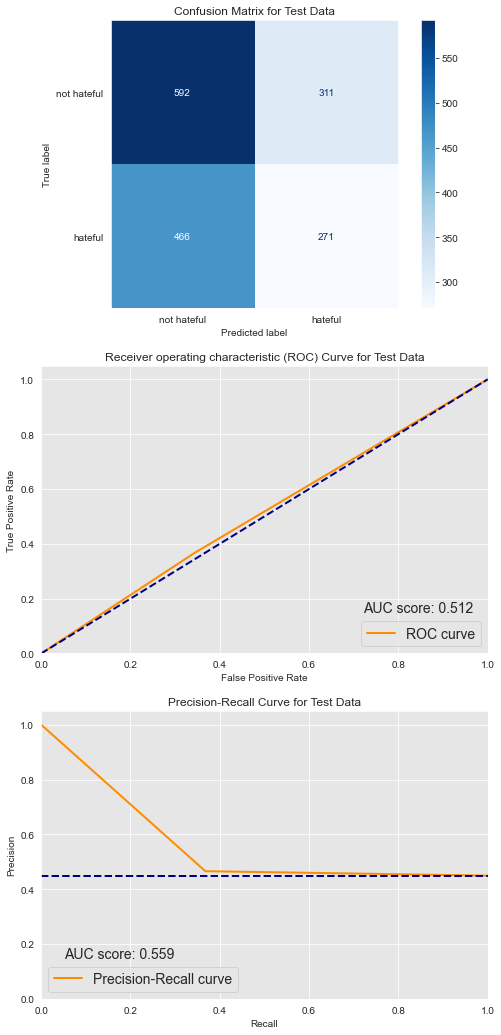

In [9]:
# evaluate model on train and test
evaluate(dummy, X_train, y_train, X_test, y_test)

## Bag of Words - Count Vectorization

In [10]:
# pipeline of vectorizer and classifier
count_mnb = Pipeline([('vect', CountVectorizer()),
                      ('clf', MultinomialNB())])

# fit on train
count_mnb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

Training Metrics
Accuracy: 0.824
Precision: 0.790
Recall: 0.685
f1: 0.734
----------
Testing Metrics
Accuracy: 0.591
Precision: 0.575
Recall: 0.343
f1: 0.430


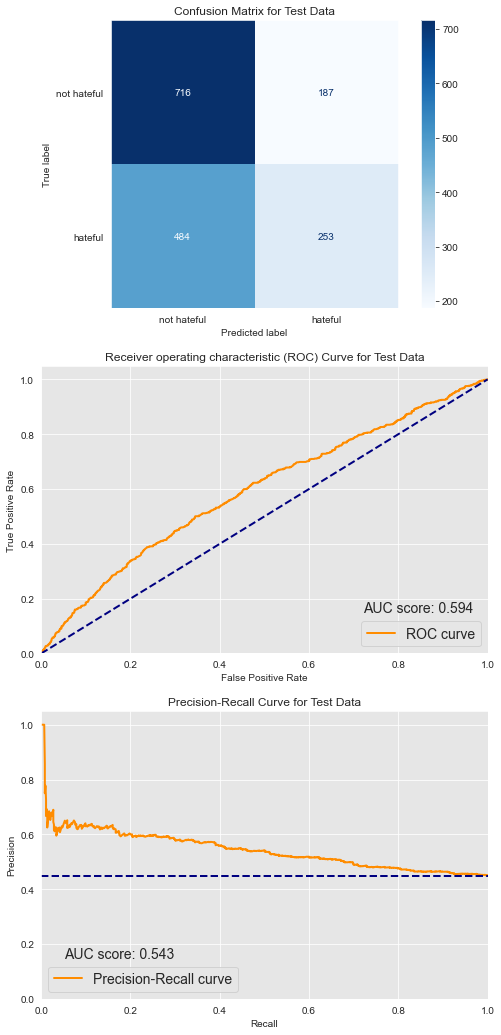

In [11]:
# evaluate model on train and test
evaluate(count_mnb, X_train, y_train, X_test, y_test)

In [12]:
# vocabulary size
len(count_mnb['vect'].vocabulary_)

8853

In [27]:
# relevant scoring metrics
scoring_metrics = ('accuracy', 'recall', 'roc_auc')

In [13]:
# parameter grid
count_grid = {
    "vect__max_df": (0.5, 0.65, 0.8,),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
count_gs = GridSearchCV(estimator=count_mnb, param_grid=count_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
count_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.65, 0.8),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'recall', 'roc_auc'))

Training Metrics
Accuracy: 0.766
Precision: 0.699
Recall: 0.600
f1: 0.646
----------
Testing Metrics
Accuracy: 0.602
Precision: 0.593
Recall: 0.364
f1: 0.451

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 2000, 'vect__ngram_range': (1, 1), 'vect__stop_words': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
16,0.191687,0.005760,0.082580,0.005403,1,0.65,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.65, 'vect_...",0.712941,0.663529,0.683529,0.685882,0.715882,0.692353,0.019637,16,0.499171,0.435430,0.456954,0.468543,0.529801,0.477980,0.033094,58,0.720067,0.669204,0.694798,0.694303,0.729299,0.701534,0.021247,1
4,0.193817,0.015553,0.079310,0.007643,1,0.5,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.712941,0.663529,0.683529,0.685882,0.715882,0.692353,0.019637,16,0.499171,0.435430,0.456954,0.468543,0.529801,0.477980,0.033094,58,0.720067,0.669204,0.694798,0.694303,0.729299,0.701534,0.021247,1
28,0.205893,0.037935,0.088084,0.015102,1,0.8,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.712941,0.663529,0.683529,0.685882,0.715882,0.692353,0.019637,16,0.499171,0.435430,0.456954,0.468543,0.529801,0.477980,0.033094,58,0.720067,0.669204,0.694798,0.694303,0.729299,0.701534,0.021247,1
5,0.175840,0.013193,0.086658,0.010527,1,0.5,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,13,0.520730,0.455298,0.465232,0.468543,0.519868,0.485934,0.028397,37,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
29,0.181207,0.007652,0.087480,0.007653,1,0.8,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.718824,0.664118,0.688235,0.687059,0.704706,0.692588,0.018413,13,0.520730,0.455298,0.465232,0.468543,0.519868,0.485934,0.028397,37,0.713720,0.673423,0.692264,0.697899,0.729506,0.701362,0.019079,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.369000,0.036619,0.124821,0.010118,0.1,0.65,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.65, 'vec...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.548922,0.549669,0.533113,0.498344,0.561258,0.538261,0.021875,1,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
39,0.369067,0.016898,0.138415,0.026842,0.1,0.5,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.633529,0.631176,0.635294,0.620588,0.651176,0.634353,0.009840,67,0.548922,0.549669,0.533113,0.498344,0.561258,0.538261,0.021875,1,0.625151,0.610827,0.616557,0.607384,0.642193,0.620422,0.012436,67
62,0.535926,0.015355,0.164361,0.001323,0.1,0.8,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.8, 'vect...",0.639412,0.624706,0.631765,0.612353,0.629412,0.627529,0.008955,70,0.548922,0.498344,0.509934,0.480132,0.529801,0.513427,0.023984,16,0.627859,0.606055,0.617266,0.605621,0.627678,0.616896,0.009810,70
50,0.499842,0.014668,0.147592,0.007135,0.1,0.65,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.65, 'vec...",0.639412,0.624706,0.631765,0.612353,0.629412,0.627529,0.008955,70,0.548922,0.498344,0.509934,0.480132,0.529801,0.513427,0.023984,16,0.627859,0.606055,0.617266,0.605621,0.627678,0.616896,0.009810,70


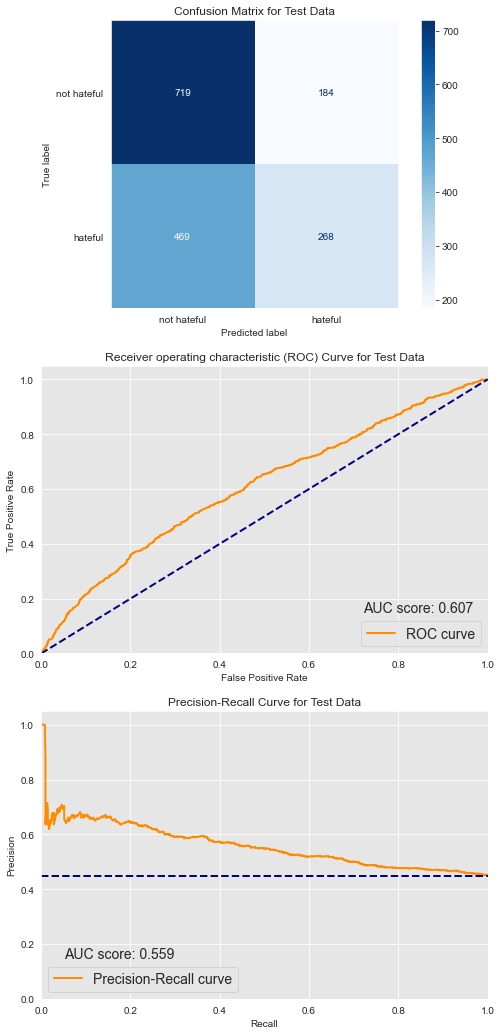

In [14]:
# evaluate model on train and test
evaluate(count_gs, X_train, y_train, X_test, y_test, grid_search=True)

## Bag of Words - Boolean Vectorization

In [15]:
# pipeline of vectorizer and classifier
bool_bnb = Pipeline([('vect', CountVectorizer(binary=True)),
                     ('clf', BernoulliNB())])

# fit on train
bool_bnb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(binary=True)), ('clf', BernoulliNB())])

Training Metrics
Accuracy: 0.819
Precision: 0.869
Recall: 0.578
f1: 0.694
----------
Testing Metrics
Accuracy: 0.585
Precision: 0.630
Recall: 0.185
f1: 0.285


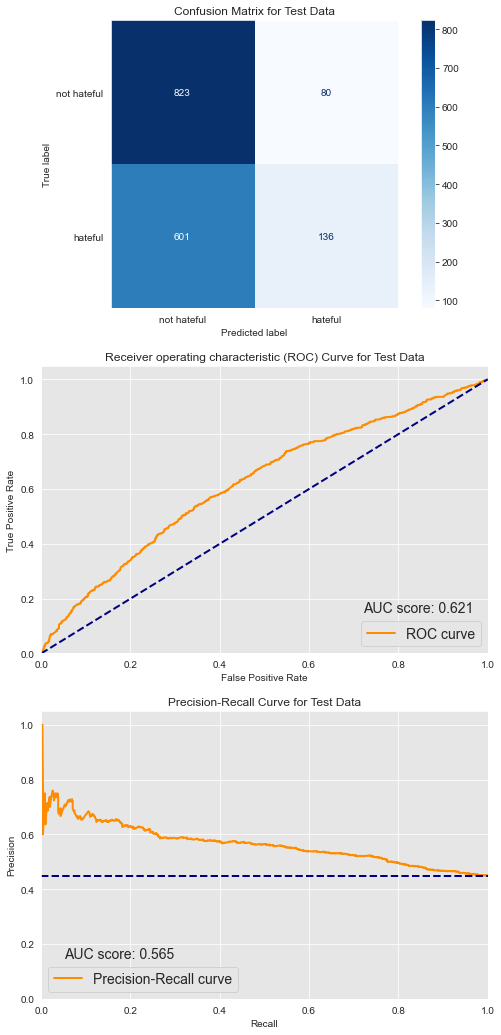

In [16]:
# evaluate model on train and test
evaluate(bool_bnb, X_train, y_train, X_test, y_test)

In [17]:
# parameter grid
bool_grid = {
    "vect__max_df": (0.5, 0.65, 0.8,),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
bool_gs = GridSearchCV(estimator=bool_bnb, param_grid=bool_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
bool_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer(binary=True)),
                                       ('clf', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.65, 0.8),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'recall', 'roc_auc'))

Training Metrics
Accuracy: 0.777
Precision: 0.758
Recall: 0.547
f1: 0.636
----------
Testing Metrics
Accuracy: 0.599
Precision: 0.648
Recall: 0.237
f1: 0.348

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
31,0.386304,0.037788,0.123912,0.010490,1,0.8,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.456053,0.400662,0.413907,0.418874,0.455298,0.428959,0.022613,49,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
19,0.329101,0.007645,0.128595,0.014027,1,0.65,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.65, 'vect_...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.456053,0.400662,0.413907,0.418874,0.455298,0.428959,0.022613,49,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
7,0.369153,0.024827,0.124317,0.018881,1,0.5,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.741765,0.708824,0.715294,0.720000,0.737647,0.724706,0.012818,1,0.456053,0.400662,0.413907,0.418874,0.455298,0.428959,0.022613,49,0.751305,0.705895,0.722703,0.725323,0.752641,0.731573,0.017946,1
17,0.168843,0.011548,0.081230,0.006248,1,0.65,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.65, 'vect_...",0.732353,0.703529,0.713529,0.708824,0.728235,0.717294,0.011152,7,0.474295,0.413907,0.430464,0.415563,0.486755,0.444197,0.030473,40,0.747736,0.706410,0.716106,0.724640,0.752792,0.729537,0.017951,4
29,0.169430,0.003584,0.082332,0.005304,1,0.8,2000,"(1, 1)",english,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.732353,0.703529,0.713529,0.708824,0.728235,0.717294,0.011152,7,0.474295,0.413907,0.430464,0.415563,0.486755,0.444197,0.030473,40,0.747736,0.706410,0.716106,0.724640,0.752792,0.729537,0.017951,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.351660,0.013210,0.131647,0.004461,0.1,0.65,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.65, 'vec...",0.667647,0.665294,0.666471,0.647647,0.678235,0.665059,0.009854,67,0.449420,0.433775,0.453642,0.399007,0.453642,0.437897,0.020775,43,0.643740,0.623282,0.631021,0.618408,0.657514,0.634793,0.014223,67
63,0.357595,0.009403,0.144072,0.011909,0.1,0.8,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.8, 'vect...",0.667647,0.665294,0.666471,0.647647,0.678235,0.665059,0.009854,67,0.449420,0.433775,0.453642,0.399007,0.453642,0.437897,0.020775,43,0.643740,0.623282,0.631021,0.618408,0.657514,0.634793,0.014223,67
62,0.499780,0.019975,0.160871,0.011251,0.1,0.8,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.8, 'vect...",0.665882,0.658235,0.655882,0.637647,0.664706,0.656471,0.010141,70,0.480929,0.412252,0.450331,0.407285,0.476821,0.445523,0.031066,37,0.640322,0.618889,0.625072,0.616456,0.640664,0.628281,0.010360,70
38,0.483672,0.008452,0.185868,0.024620,0.1,0.5,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.5, 'vect...",0.665882,0.658235,0.655882,0.637647,0.664706,0.656471,0.010141,70,0.480929,0.412252,0.450331,0.407285,0.476821,0.445523,0.031066,37,0.640322,0.618889,0.625072,0.616456,0.640664,0.628281,0.010360,70


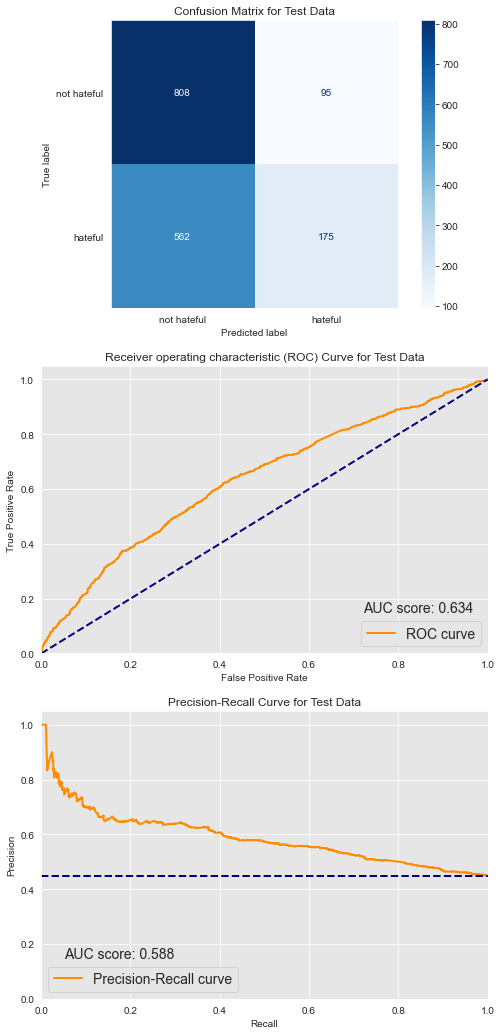

In [19]:
# evaluate model on train and test
evaluate(bool_gs, X_train, y_train, X_test, y_test, grid_search=True)

## Bag of Words - TF-IDF Vectorization

In [20]:
# pipeline of vectorizer and classifier
tfidf_mnb = Pipeline([('vect', TfidfVectorizer()),
                      ('clf', MultinomialNB())])

# fit on train
tfidf_mnb.fit(X_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer()), ('clf', MultinomialNB())])

Training Metrics
Accuracy: 0.761
Precision: 0.920
Recall: 0.359
f1: 0.517
----------
Testing Metrics
Accuracy: 0.563
Precision: 0.608
Recall: 0.080
f1: 0.141


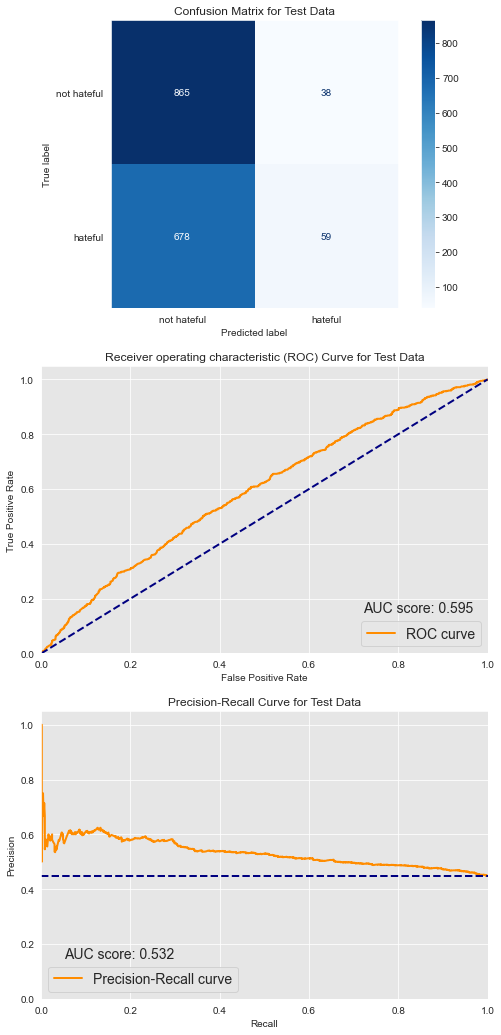

In [22]:
# evaluate model on train and test
evaluate(tfidf_mnb, X_train, y_train, X_test, y_test)

In [23]:
# parameter grid
tfidf_grid = {
    "vect__max_df": (0.5, 0.65, 0.8),
    'vect__max_features': (None, 2000, 4000),
    "vect__ngram_range": ((1, 1), (1, 2)),
    "vect__stop_words": (None, 'english'),
    "clf__alpha": (1, 0.1),
}

# refit on roc_auc
tfidf_gs = GridSearchCV(estimator=tfidf_mnb, param_grid=tfidf_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
tfidf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': (1, 0.1),
                         'vect__max_df': (0.5, 0.65, 0.8),
                         'vect__max_features': (None, 2000, 4000),
                         'vect__ngram_range': ((1, 1), (1, 2)),
                         'vect__stop_words': (None, 'english')},
             refit='roc_auc', scoring=('accuracy', 'recall', 'roc_auc'))

Training Metrics
Accuracy: 0.756
Precision: 0.786
Recall: 0.430
f1: 0.556
----------
Testing Metrics
Accuracy: 0.590
Precision: 0.642
Recall: 0.199
f1: 0.304

Best Parameters
{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__max_features': 2000, 'vect__ngram_range': (1, 2), 'vect__stop_words': 'english'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__alpha,param_vect__max_df,param_vect__max_features,param_vect__ngram_range,param_vect__stop_words,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
19,0.388882,0.008439,0.144613,0.029728,1,0.65,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.65, 'vect_...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,1,0.341625,0.274834,0.289735,0.311258,0.332781,0.310047,0.025171,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
31,0.396499,0.026059,0.124971,0.000001,1,0.8,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,1,0.341625,0.274834,0.289735,0.311258,0.332781,0.310047,0.025171,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
7,0.470928,0.024241,0.116886,0.005440,1,0.5,2000,"(1, 2)",english,"{'clf__alpha': 1, 'vect__max_df': 0.5, 'vect__...",0.712941,0.667647,0.678824,0.693529,0.705294,0.691647,0.016635,1,0.341625,0.274834,0.289735,0.311258,0.332781,0.310047,0.025171,37,0.715641,0.665938,0.694549,0.697997,0.727622,0.700349,0.020981,1
28,0.196968,0.012399,0.095345,0.009682,1,0.8,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.8, 'vect__...",0.701176,0.675294,0.682353,0.692353,0.699412,0.690118,0.009937,10,0.271973,0.228477,0.220199,0.261589,0.281457,0.252739,0.024168,55,0.712896,0.661551,0.690923,0.692608,0.719600,0.695516,0.020324,4
16,0.188271,0.001609,0.083703,0.008358,1,0.65,2000,"(1, 1)",None,"{'clf__alpha': 1, 'vect__max_df': 0.65, 'vect_...",0.701176,0.675294,0.682353,0.692353,0.699412,0.690118,0.009937,10,0.271973,0.228477,0.220199,0.261589,0.281457,0.252739,0.024168,55,0.712896,0.661551,0.690923,0.692608,0.719600,0.695516,0.020324,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.392960,0.013979,0.128257,0.006103,0.1,0.8,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.8, 'vect...",0.641765,0.632941,0.644706,0.636471,0.656471,0.642471,0.008103,70,0.459370,0.422185,0.440397,0.418874,0.455298,0.439225,0.016553,1,0.628982,0.609213,0.617303,0.611521,0.642524,0.621909,0.012372,67
51,0.421422,0.012575,0.138151,0.008730,0.1,0.65,None,"(1, 2)",english,"{'clf__alpha': 0.1, 'vect__max_df': 0.65, 'vec...",0.641765,0.632941,0.644706,0.636471,0.656471,0.642471,0.008103,70,0.459370,0.422185,0.440397,0.418874,0.455298,0.439225,0.016553,1,0.628982,0.609213,0.617303,0.611521,0.642524,0.621909,0.012372,67
50,0.581906,0.019362,0.178921,0.005871,0.1,0.65,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.65, 'vec...",0.641765,0.647059,0.644706,0.643529,0.645294,0.644471,0.001769,67,0.417910,0.390728,0.412252,0.399007,0.430464,0.410072,0.013990,7,0.630464,0.603897,0.613568,0.609571,0.628248,0.617149,0.010453,70
62,0.547575,0.029202,0.167353,0.006834,0.1,0.8,None,"(1, 2)",None,"{'clf__alpha': 0.1, 'vect__max_df': 0.8, 'vect...",0.641765,0.647059,0.644706,0.643529,0.645294,0.644471,0.001769,67,0.417910,0.390728,0.412252,0.399007,0.430464,0.410072,0.013990,7,0.630464,0.603897,0.613568,0.609571,0.628248,0.617149,0.010453,70


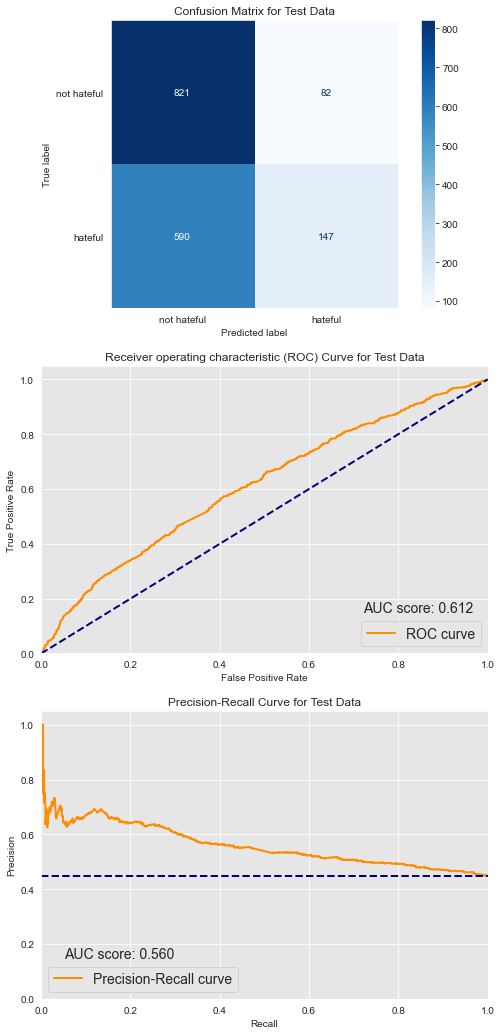

In [27]:
# evaluate model on train and test
evaluate(tfidf_gs, X_train, y_train, X_test, y_test, grid_search=True)

In [26]:
tfidf_gs.best_estimator_['vect'].vocabulary_

{'color': 354,
 'don': 495,
 'love': 1079,
 'like': 1035,
 'ex': 576,
 'putting': 1435,
 'pet': 1339,
 'everybody': 570,
 'hate': 788,
 'loves': 1083,
 'chocolate': 324,
 'hitler': 825,
 'sports': 1674,
 'thing': 1779,
 'win': 1949,
 'points': 1372,
 'fine': 624,
 'right': 1510,
 'fucking': 679,
 'drop': 518,
 'tattoos': 1754,
 'bad': 144,
 'know': 991,
 'million': 1153,
 'people': 1326,
 'died': 464,
 'long': 1063,
 'run': 1519,
 'till': 1792,
 'hiding': 816,
 'need': 1230,
 'tax': 1755,
 'returns': 1504,
 'let': 1018,
 'stop': 1702,
 'hillary': 821,
 '30': 25,
 '000': 0,
 'used': 1861,
 'bit': 191,
 'hard': 782,
 'destroyed': 449,
 'talk': 1747,
 'truth': 1837,
 'tax returns': 1756,
 'jew': 932,
 'mad': 1088,
 'removes': 1489,
 'polish': 1376,
 'chemicals': 309,
 'bats': 158,
 'eye': 587,
 'removes polish': 1490,
 'polish chemicals': 1377,
 'chemicals bats': 310,
 'bats eye': 159,
 'brother': 248,
 'day': 427,
 'blast': 204,
 'wasted': 1905,
 'dog': 488,
 'left': 1014,
 'black': 194,

## GloVe Word Embeddings

In [6]:
# tokenize the meme text
X_train_token = X_train.map(word_tokenize)

# unique tokens in training set
vocabulary = set(token for meme in X_train_token for token in meme)

# vocabulary size
len(vocabulary)

9178

In [7]:
# generate GloVe embeddings for the corpus vocab
glove = generate_glove(vocabulary)

# proportion of vocab with GloVe embedding
print(f'Found embeddings for {len(glove)/len(vocabulary):.2%} of vocabulary')

# which tokens don't have GloVe embeddings
missing_embeddings = sorted(list(vocabulary.difference(set(glove))))
missing_embeddings[:20]

Found embeddings for 89.54% of vocabulary


["''did",
 "''dont",
 "''oh",
 "'ahly",
 "'bigoted",
 "'bout",
 "'cruising",
 "'dark",
 "'dog",
 "'donnell",
 "'eliminate",
 "'first",
 "'guess",
 "'just",
 "'load",
 "'macho",
 "'nationalism",
 "'negotiate'with",
 "'palestinian",
 "'peaceful"]

In [8]:
# strip tokens without an embedding of punctuation
X_train_token = X_train_token.map(lambda x: list(strip_punctuation(x, glove)))

# unique tokens in training set
vocabulary = set(token for meme in X_train_token for token in meme)

# vocabulary size
len(vocabulary)

9098

In [9]:
# generate GloVe embeddings again
glove = generate_glove(vocabulary)

# proportion of vocab with GloVe embedding
print(f'Found embeddings for {len(glove)/len(vocabulary):.2%} of vocabulary')

# which tokens don't have GloVe embeddings
missing_embeddings = sorted(list(vocabulary.difference(set(glove))))
missing_embeddings[:20]

Found embeddings for 90.55% of vocabulary


['',
 '01/08/19',
 '0mar',
 '1-800-abos-r-dum',
 '1-800-you-lost',
 '1-866-347-2423',
 '1/1024th',
 '1024/1024th',
 '10\\10',
 '12:30pm',
 '1400/wk',
 '154km',
 '157,876',
 '159cm',
 '15august1947',
 '169cm',
 '1:8-9',
 '2+2',
 '2014and',
 '21:33']

### GloVe - Logistic Regression

In [20]:
# pipeline of tokenizer, vectorizer, and classifier
glove_lr = Pipeline([('token', W2vTokenizer(glove)),
                     ('vect', W2vVectorizer(glove)),
                     ('scaler', StandardScaler()),
                     ('clf', LogisticRegression(solver='saga', max_iter=1000, random_state=42))])

# fit on train
glove_lr.fit(X_train, y_train)

Pipeline(steps=[('token', <utils.W2vTokenizer object at 0x000002107C9DB370>),
                ('vect', <utils.W2vVectorizer object at 0x000002107C9DB520>),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(max_iter=1000, random_state=42,
                                    solver='saga'))])

Training Metrics
Accuracy: 0.699
Precision: 0.635
Recall: 0.359
f1: 0.459
----------
Testing Metrics
Accuracy: 0.568
Precision: 0.548
Recall: 0.216
f1: 0.310


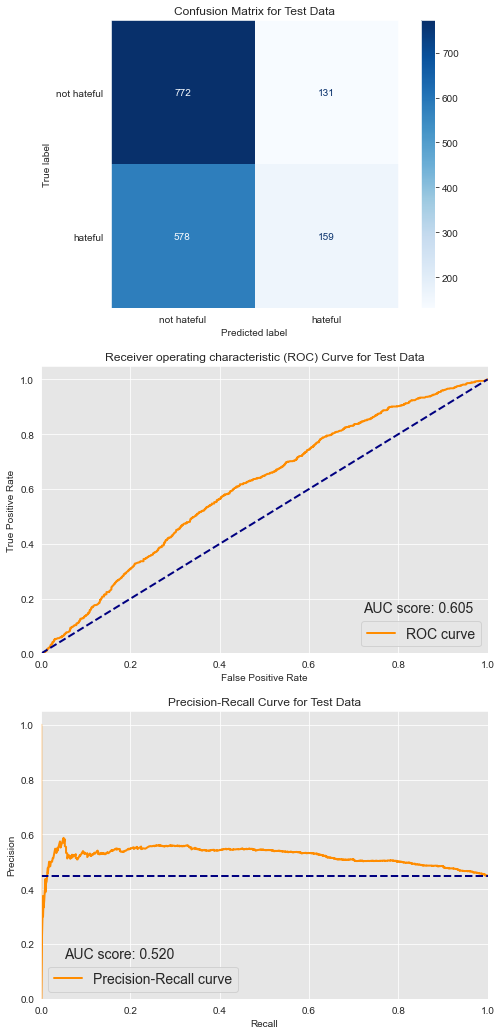

In [22]:
# evaluate model on train and test
evaluate(glove_lr, X_train, y_train, X_test, y_test)

In [42]:
# parameter grid
glovelr_grid = {
    "clf__penalty": ['elasticnet'],
    "clf__l1_ratio": (0, 0.5, 1),
    "clf__C": (0.1, 1e-2, 1e-3)
}

# refit on roc_auc
glovelr_gs = GridSearchCV(estimator=glove_lr, param_grid=glovelr_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
glovelr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('token',
                                        <utils.W2vTokenizer object at 0x000002107C9DB370>),
                                       ('vect',
                                        <utils.W2vVectorizer object at 0x000002107C9DB520>),
                                       ('scaler', StandardScaler()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': (0.1, 0.01, 0.001),
                         'clf__l1_ratio': (0, 0.5, 1),
                         'clf__penalty': ['elasticnet']},
             refit='roc_auc', scoring=('accuracy', 'recall', 'roc_auc'))

Training Metrics
Accuracy: 0.682
Precision: 0.642
Recall: 0.233
f1: 0.342
----------
Testing Metrics
Accuracy: 0.562
Precision: 0.546
Recall: 0.153
f1: 0.239

Best Parameters
{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__penalty': 'elasticnet'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__l1_ratio,param_clf__penalty,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
6,2.491339,0.088295,0.899930,0.067415,0.001,0,elasticnet,"{'clf__C': 0.001, 'clf__l1_ratio': 0, 'clf__pe...",0.670000,0.665882,0.674118,0.657059,0.682353,0.669882,0.008413,4,0.197347,0.226821,0.198675,0.180464,0.245033,0.209668,0.023110,5,0.724693,0.679286,0.668151,0.654345,0.746980,0.694691,0.035224,1
3,6.545544,0.372150,1.219241,0.057819,0.01,0,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 0, 'clf__pen...",0.684706,0.665882,0.666471,0.650588,0.685294,0.670588,0.013074,3,0.288557,0.307947,0.274834,0.245033,0.312914,0.285857,0.024558,3,0.714561,0.681268,0.670096,0.654424,0.735762,0.691222,0.029759,2
1,20.347458,2.115922,1.200130,0.043975,0.1,0.5,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 0.5, 'clf__pe...",0.682353,0.662353,0.668235,0.650000,0.684118,0.669412,0.012742,5,0.291874,0.312914,0.293046,0.250000,0.316225,0.292812,0.023605,2,0.712663,0.680185,0.668160,0.653282,0.734037,0.689665,0.029577,3
2,13.453586,1.125172,1.307284,0.181391,0.1,1,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 1, 'clf__pena...",0.682353,0.667059,0.668235,0.651765,0.684706,0.670824,0.011914,2,0.275290,0.288079,0.266556,0.236755,0.299669,0.273270,0.021442,4,0.714297,0.679286,0.666585,0.651895,0.735269,0.689466,0.030832,4
0,20.534671,1.465524,1.284857,0.157430,0.1,0,elasticnet,"{'clf__C': 0.1, 'clf__l1_ratio': 0, 'clf__pena...",0.677647,0.670000,0.666471,0.653529,0.688824,0.671294,0.011732,1,0.313433,0.341060,0.306291,0.278146,0.350993,0.317985,0.025948,1,0.710264,0.679247,0.668434,0.653360,0.731244,0.688510,0.028368,5
4,5.252032,0.330670,1.186665,0.100085,0.01,0.5,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 0.5, 'clf__p...",0.665882,0.664118,0.662353,0.654706,0.678824,0.665176,0.007816,6,0.155887,0.195364,0.163907,0.167219,0.203642,0.177204,0.018760,6,0.720604,0.667940,0.653716,0.652946,0.738349,0.686711,0.035767,6
5,3.946892,0.175612,1.039455,0.046426,0.01,1,elasticnet,"{'clf__C': 0.01, 'clf__l1_ratio': 1, 'clf__pen...",0.658824,0.654118,0.651176,0.647647,0.660588,0.654471,0.004773,7,0.107794,0.124172,0.105960,0.117550,0.110927,0.113281,0.006724,7,0.703985,0.656231,0.637155,0.635490,0.727206,0.672014,0.037058,7
7,2.141508,0.051151,0.896560,0.069608,0.001,0.5,elasticnet,"{'clf__C': 0.001, 'clf__l1_ratio': 0.5, 'clf__...",0.645294,0.644706,0.644706,0.644706,0.644706,0.644824,0.000235,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,8
8,1.765873,0.142585,0.696242,0.086561,0.001,1,elasticnet,"{'clf__C': 0.001, 'clf__l1_ratio': 1, 'clf__pe...",0.645294,0.644706,0.644706,0.644706,0.644706,0.644824,0.000235,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,8


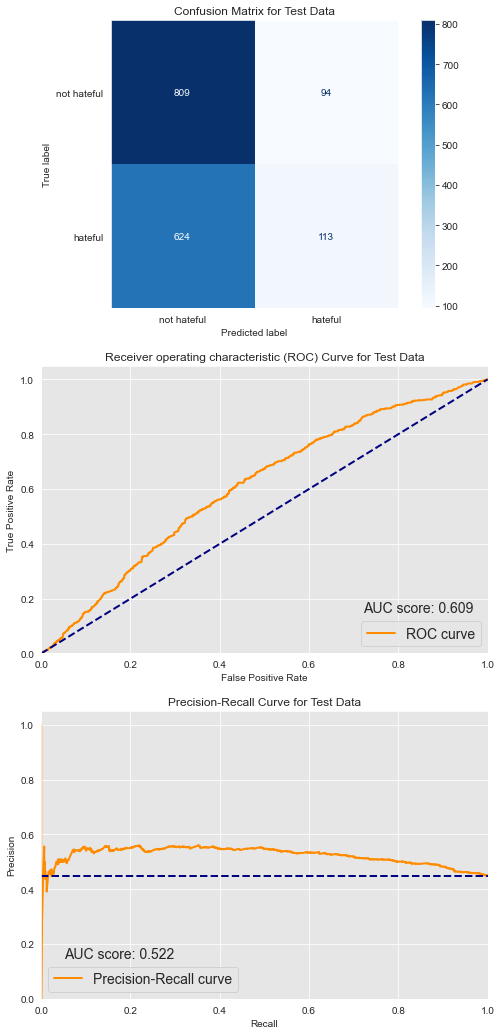

In [43]:
# evaluate model on train and test
evaluate(glovelr_gs, X_train, y_train, X_test, y_test, grid_search=True)

### GloVe - Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
# pipeline of tokenizer, vectorizer, and classifier
glove_rf = Pipeline([('token', W2vTokenizer(glove)),
                     ('vect', W2vVectorizer(glove)),
                     ('clf', RandomForestClassifier(random_state=42))])

# parameter grid
gloverf_grid = {
    "clf__n_estimators": [1000],
    "clf__max_depth": (8, 10),
    "clf__min_samples_split": (5, 10),
    "clf__max_samples": (0.25, 0.5, 0.75)
}

# refit on roc_auc
gloverf_gs = GridSearchCV(estimator=glove_rf, param_grid=gloverf_grid, scoring=scoring_metrics, refit='roc_auc', n_jobs=-1)

# fit on train
gloverf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('token',
                                        <utils.W2vTokenizer object at 0x000002100C5B1490>),
                                       ('vect',
                                        <utils.W2vVectorizer object at 0x000002100C5B12E0>),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': (8, 10),
                         'clf__max_samples': (0.25, 0.5, 0.75),
                         'clf__min_samples_split': (5, 10),
                         'clf__n_estimators': [1000]},
             refit='roc_auc', scoring=('accuracy', 'recall', 'roc_auc'))

Training Metrics
Accuracy: 0.728
Precision: 0.915
Recall: 0.258
f1: 0.402
----------
Testing Metrics
Accuracy: 0.557
Precision: 0.608
Recall: 0.042
f1: 0.079

Best Parameters
{'clf__max_depth': 8, 'clf__max_samples': 0.25, 'clf__min_samples_split': 10, 'clf__n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__max_depth,param_clf__max_samples,param_clf__min_samples_split,param_clf__n_estimators,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,split4_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,split3_test_roc_auc,split4_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
1,31.500409,0.245571,2.455291,0.146174,8,0.25,10,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.25...",0.682353,0.672353,0.678824,0.671765,0.670000,0.675059,0.004715,3,0.142620,0.135762,0.149007,0.149007,0.125828,0.140445,0.008797,12,0.720257,0.663410,0.656035,0.650573,0.726939,0.683443,0.033106,1
0,30.579086,0.806911,2.242716,0.130487,8,0.25,5,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.25...",0.679412,0.671176,0.680588,0.668824,0.671765,0.674353,0.004729,4,0.142620,0.132450,0.160596,0.152318,0.132450,0.144087,0.011075,11,0.720228,0.663979,0.653747,0.647664,0.727069,0.682537,0.034039,2
3,58.096443,0.337971,2.277590,0.198434,8,0.5,10,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.5,...",0.679412,0.671176,0.676471,0.670588,0.672353,0.674000,0.003398,6,0.154229,0.152318,0.165563,0.165563,0.140728,0.155680,0.009298,10,0.716701,0.663055,0.651402,0.645313,0.721194,0.679533,0.032714,3
2,57.644856,0.720000,2.138546,0.102275,8,0.5,5,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.5,...",0.682353,0.668235,0.675882,0.671176,0.671765,0.673882,0.004888,7,0.165837,0.153974,0.165563,0.163907,0.145695,0.158995,0.007952,9,0.715625,0.661127,0.649173,0.644531,0.718310,0.677753,0.032484,4
5,84.173350,0.956834,2.445865,0.200843,8,0.75,10,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.75...",0.679412,0.668235,0.672941,0.667059,0.672941,0.672118,0.004364,9,0.165837,0.157285,0.172185,0.163907,0.149007,0.161644,0.007906,8,0.715226,0.659758,0.645576,0.646050,0.717620,0.676846,0.032722,5
7,41.576383,0.946525,2.434078,0.157295,10,0.25,10,1000,"{'clf__max_depth': 10, 'clf__max_samples': 0.2...",0.687059,0.674118,0.680588,0.674706,0.681176,0.679529,0.004756,1,0.195688,0.168874,0.188742,0.182119,0.187086,0.184502,0.008941,6,0.712239,0.653444,0.649461,0.644355,0.718261,0.675552,0.032596,6
4,80.174925,1.789546,2.344552,0.062439,8,0.75,5,1000,"{'clf__max_depth': 8, 'clf__max_samples': 0.75...",0.682941,0.668235,0.675294,0.672353,0.672353,0.674235,0.004899,5,0.175788,0.167219,0.177152,0.173841,0.153974,0.169595,0.008523,7,0.712459,0.657570,0.643297,0.641883,0.715662,0.674174,0.033042,7
6,40.635516,1.347463,2.415332,0.097520,10,0.25,5,1000,"{'clf__max_depth': 10, 'clf__max_samples': 0.2...",0.686471,0.670588,0.679412,0.675882,0.685294,0.679529,0.005911,1,0.200663,0.185430,0.195364,0.195364,0.197020,0.194768,0.005054,5,0.709518,0.657208,0.645877,0.639330,0.717005,0.673788,0.032820,8
9,72.866507,0.432349,2.509022,0.124393,10,0.5,10,1000,"{'clf__max_depth': 10, 'clf__max_samples': 0.5...",0.682941,0.665294,0.668824,0.670000,0.674706,0.672353,0.006090,8,0.225539,0.193709,0.215232,0.206954,0.206954,0.209677,0.010510,4,0.704370,0.653349,0.637830,0.635175,0.705531,0.667251,0.031403,9
8,72.259037,1.024491,2.493164,0.094557,10,0.5,5,1000,"{'clf__max_depth': 10, 'clf__max_samples': 0.5...",0.678235,0.660000,0.663529,0.668235,0.671765,0.668353,0.006362,10,0.243781,0.195364,0.225166,0.223510,0.218543,0.221273,0.015527,3,0.698551,0.645882,0.634707,0.632355,0.702503,0.662800,0.031167,10


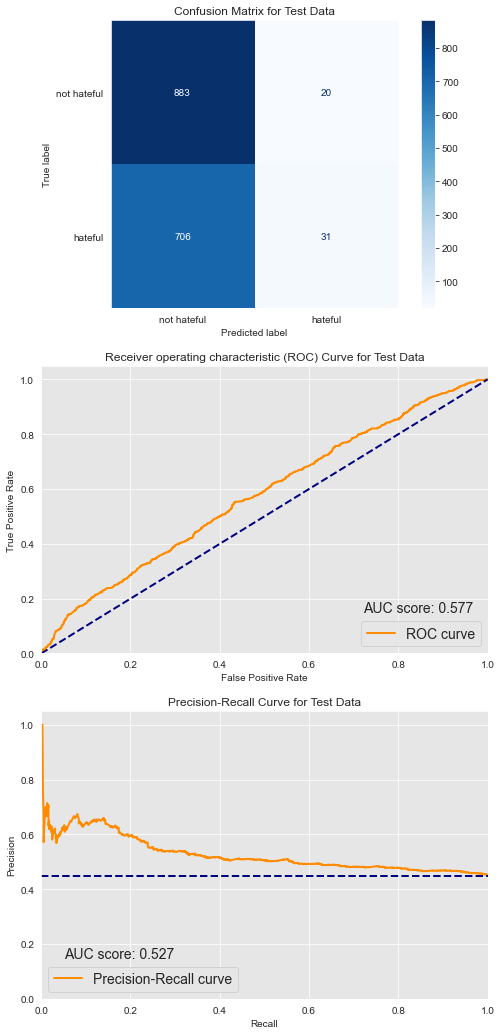

In [47]:
# evaluate model on train and test
evaluate(gloverf_gs, X_train, y_train, X_test, y_test, grid_search=True)